In [1]:
import jax
import numpyro
import blackjax
import numpy as np
import jax.numpy as jnp
import numpyro.distributions as dist
from numpyro.infer.util import initialize_model
from numpyro.infer.reparam import LocScaleReparam
from numpyro.handlers import reparam
from numpyro.infer.reparam import TransformReparam
import matplotlib.pyplot as plt

/Users/madhav/anaconda3/envs/experiment/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Model initialization values
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [3]:
def eight_schools():
    mu = numpyro.sample('mu', dist.Normal(2, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    theta = numpyro.sample('theta', dist.Normal(jnp.full(J,mu), tau))
    numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

In [4]:
# reparam_model = reparam(eight_schools, config={"theta": LocScaleReparam(centered=jnp.array([0.1,0.2,0.3,0.4,0.5,0.6,0.1,0.2]))})
# samples_locscale = inference(eight_schools_noncentered)

In [5]:

# init_params, potential_fn_gen, *_ = initialize_model(
#     rng_key,
#     reparam_model,
#     dynamic_args=True,
# )

In [6]:
# logdensity_fn = lambda position: -potential_fn_gen()(position)
# initial_position = init_params.z

In [7]:
# num_warmup = 200

# adapt = blackjax.window_adaptation(
#     blackjax.nuts, eight_schools)
# (last_state, parameters), intermediate_states = adapt.run(rng_key, initial_position, num_warmup)

In [8]:
rng_key = jax.random.PRNGKey(0)

In [9]:
num_warmup = 150

adapt = blackjax.window_adaptation(
    blackjax.nuts, eight_schools, target_acceptance_rate=0.8
)
(last_state, parameters), intermediate_states, logdensity_fn = adapt.run(rng_key, num_warmup)

[2.0506687e-01 2.9211643e-01 3.8131201e-01 1.7185305e-06 1.3638337e-01
 1.2478772e-01 3.0126449e-07 2.7286555e-07]
Entered
Old:  <function window_adaptation.<locals>.logdensity_create.<locals>.<lambda> at 0x12fbb3920>
New:  <function window_adaptation.<locals>.logdensity_create.<locals>.<lambda> at 0x2eea3b240>


In [10]:
kernel = blackjax.nuts(logdensity_fn, **parameters).step

In [11]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    extra, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )

In [12]:
num_sample = 1000

states, infos = inference_loop(rng_key, kernel, last_state, num_sample)
_ = states.position["mu"].block_until_ready()

In [16]:
def scatterplt(samples):
    fig, axes = plt.subplots(4, 2, figsize=(10, 12))
    axes = axes.flatten()
    # reparam_sample, mvn, mu_theta, std_theta = reparameterize_samples_dist(samples, best_c)
    # reparam_sample = reparam_sample if reparam else samples['theta'].T
    samples_theta = samples['theta_decentered'].T
    for i in range(8):
        axes[i].scatter(samples_theta[i], samples['tau'])
        axes[i].set_xlabel(f'theta_{i}')
        axes[i].set_ylabel('log_std')

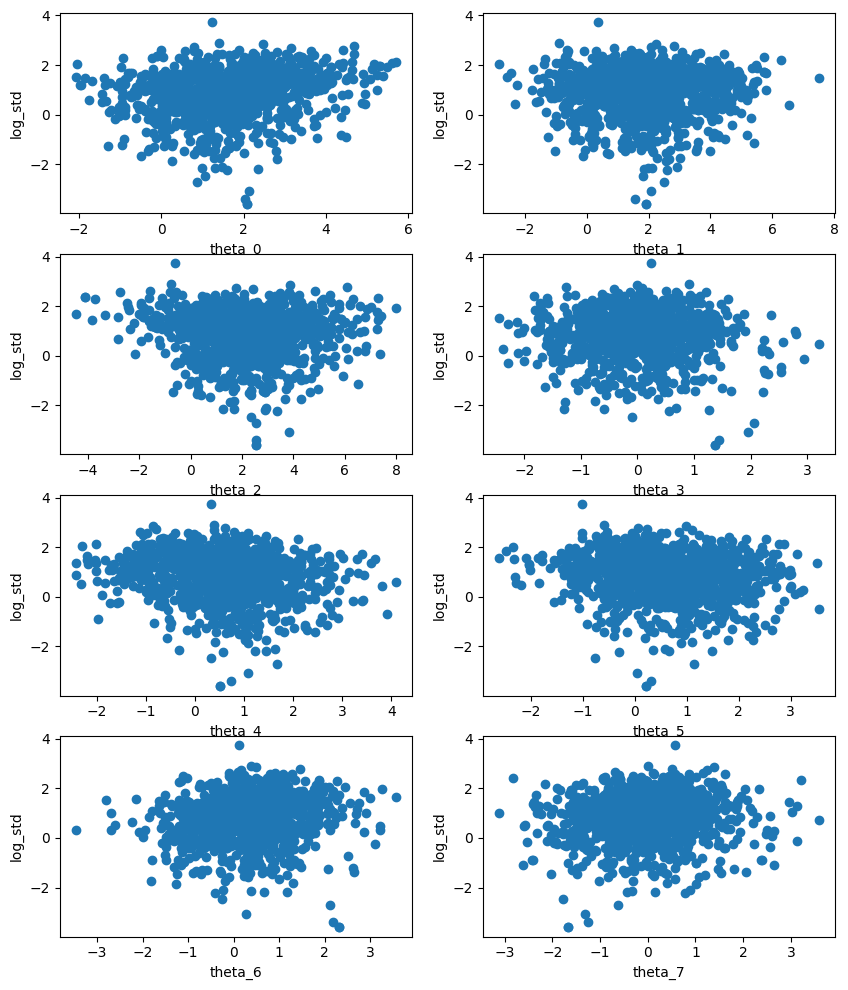

In [17]:
scatterplt(states[0])

In [ ]:
acceptance_rate = np.mean(infos[0])
num_divergent = np.mean(infos[1])

print(f"\Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

\Average acceptance rate: 0.87
There were 1.20% divergent transitions
